In [1]:
from __future__ import division
import os, sys, time, random
import math
import scipy
from scipy import constants
import torch
from torch import nn, optim
from torch import autograd
from torch.autograd import grad
import autograd.numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
from scipy.constants import pi
from scipy.special import lpmv

In [3]:
class Potential(nn.Module):
    def __init__(self):
        super(Potential,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh()
        )
#         self.hidden2 = nn.Sequential(
#             nn.Linear(128,128),
#             nn.Tanh()
#         )
        self.out = nn.Sequential(
            nn.Linear(64,1),
           # nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = x + self.hidden1(x)
       # x = x + self.hidden2(x)
        x = self.out(x)
        return x

In [4]:
#Solution is the Legendre polynomial. LPMV(m,n)
#Let's do m=n=1

def init_wave_function(batch): 
    return -(torch.sqrt(1-torch.tanh(batch)**2))


In [5]:
#TODO 
#Fix this Legendre function
# def legendre_associated ( n, m, x ):

#     if ( m < 0 ):
#         print ( '' )
#         print ( 'LEGENDRE_ASSOCIATED - Fatal error!' )
#         print ( '  Input value of M is %d' % ( m ) )
#         print ( '  but M must be nonnegative.' )
 
#     if ( n < m ):
#         print ( '' )
#         print ( 'LEGENDRE_ASSOCIATED - Fatal error!' )
#         print ( '  Input value of M = %d' % ( m ) )
#         print ( '  Input value of N = %d' % ( n ) )
#         print ( '  but M must be less than or equal to N.' )
 
#     if ( x.min() < -1.0 ):
#         print ( '' )
#         print ( 'LEGENDRE_ASSOCIATED - Fatal error!' )
#         print ( '  Input value of X = %f' % ( x ) )
#         print ( '  but X must be no less than -1.' )

#     if ( 1.0 < x.max() ):
#         print ( '' )
#         print ( 'LEGENDRE_ASSOCIATED - Fatal error!' )
#         print ( '  Input value of X = %f' % ( x ) )
#         print ( '  but X must be no more than 1.' )
  
#     cx = torch.zeros(n + 1)

#     cx[m] = 1.0
#     somx2 = torch.sqrt ( 1.0 - x * x )
 
#     fact = 1.0
#     for i in range ( 0, m ):
#         cx[m] = - cx[m] * fact * somx2
#         fact = fact + 2.0
 
#     if ( m != n ):

#         cx[m+1] = x *  ( 2 * m + 1 ) * cx[m]

#         for i in range ( m + 2, n + 1 ):
#             cx[i] = ( ( 2 * i     - 1 ) * x * cx[i-1] \
#               + ( - i - m + 1 ) *  cx[i-2] ) \
#               / ( i - m )

#     return cx


In [6]:
potential = Potential()
optimizer = torch.optim.Adam(potential.parameters(), lr = .001)


def new_prob_dist(batch):
    output = init_wave_function(batch)
    output.requires_grad_(True)
    potential_energy = potential(batch)
   # potential_energy.requires_grad_(True)
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
   
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
  
    conserve_energy = grad(kinetic_energy/(-2*output) + potential_energy, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    
    return conserve_energy
      

In [7]:
x_range = [-3,3]
#Better to get from data
def sample_x(size):
    '''
    Uniform random x sampling within range
    '''
    x = (x_range[0] - x_range[1]) * torch.rand(size,1) + x_range[1]
    return x


In [8]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.data)

In [9]:
data = sample_x(2500)
dataset = MyDataset(data)
loader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [10]:
num_epochs = 200
loss = []
x = torch.tensor([0.0])
for epoch in range(num_epochs):
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch, requires_grad=True)
        optimizer.zero_grad()
       
  
        error = (total_energy**2).mean() + (potential(x)+1)**2
     
        error.backward(retain_graph=True)
      
        optimizer.step()
    loss.append(error)
  


In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, title, show, xlabel, ylabel, legend


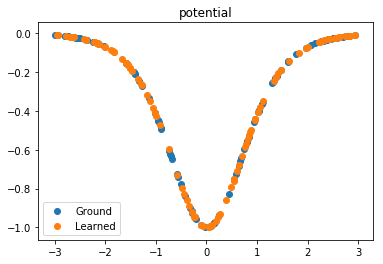

In [18]:
x = sample_x(100)
y = sample_x(100)
y1 = torch.tanh(y)
y2 = torch.sqrt(1-y1.pow(2))
x.requires_grad_(True)
a = torch.tanh(x)
b = torch.sqrt(1-a.pow(2))
plt.scatter(y, -pow(y2.detach().numpy(),2))
plt.scatter(x.detach().numpy(), potential(x).detach().numpy())
title("potential")
legend(['Ground','Learned'])
show()

The rest of the notebook is devoted to generating figures that are found in the main text and can be ignored. 

In [18]:
def learned_energy(batch):
    batch.requires_grad_(True)
    output = init_wave_function(batch)
    output.requires_grad_(True)
    potential_energy = potential(batch)
  
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    
    total_energy = -kinetic_energy/(2*output) + potential_energy
    return total_energy
      

In [24]:
def ground_energy(batch):
    batch.requires_grad_(True)
    output = init_wave_function(batch)
    output.requires_grad_(True)
    potential_energy = (torch.tanh(batch)**2 -1)
  
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    
    total_energy = -kinetic_energy/(2*output) + potential_energy
    return total_energy

In [27]:
x = sample_x(100)
torch.mean((learned_energy(x)-ground_energy(x))**2)/10

tensor(7.6631e-08, grad_fn=<DivBackward0>)

In [28]:
x_coord = sample_x(4000)
learned_energy1 = learned_energy(x_coord).detach().numpy()
learned_energy1[3000],x_coord.detach().numpy()[3000]

(array([-0.49903566], dtype=float32), array([0.4531417], dtype=float32))

In [29]:
ground_energy = ground_energy(x_coord).detach().numpy()

In [30]:
output_en=[]
for i in range(0,len(learned_energy1)):
    output_en.append((x_coord.detach().numpy()[i][0],learned_energy1[i][0]))

In [31]:
sorted_output_en = sorted(output_en, key=lambda x: x[0])

In [32]:
xsorted = []
en_sorted=[]
for i in sorted_output_en:
    xsorted.append(i[0])
    en_sorted.append(i[1])

In [33]:
dictlearned={'x':xsorted,'energy_learned':en_sorted}

In [34]:
output_ground_en=[]
for i in range(0,len(ground_energy)):
    output_ground_en.append((x_coord.detach().numpy()[i][0],ground_energy[i][0]))
sorted_ground_en = sorted(output_ground_en, key=lambda x: x[0])

In [35]:
xgroundsorted = []
engroundsorted=[]
for i in sorted_ground_en:
    xgroundsorted.append(i[0])
    engroundsorted.append(i[1])

In [36]:
dictplot= {'x':xsorted,'Learned Energy':en_sorted, 'Ground Energy':engroundsorted}

In [37]:
import pandas as pd
df=pd.DataFrame(dictplot)

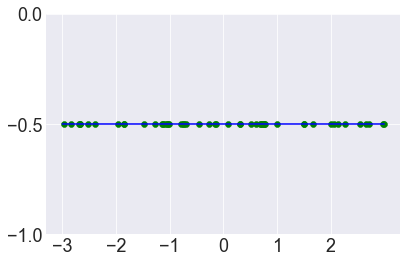

In [96]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
x = sample_x(50)
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()
# ax.set_title('Ground and Learned Potentials')
#ax.set_xlabel('Position')
#ax.set_ylabel('Potential')
plt.plot(xgroundsorted,engroundsorted,color='b',linewidth=1.5)
plt.scatter(x.detach().numpy(), learned_energy(x).detach().numpy(),color='g',linestyle='-',marker='o',linewidth=0.5)
#plt.plot(xsorted,potsorted,color='g',linewidth='1',alpha=0.5)
# Create an inset outside the axes
# plt.suptitle("Ground and Learned Potentials", fontsize=13, fontweight=0, color='black', style='italic')

#plt.legend(['Ground','Learned'],bbox_to_anchor=(0.1, 0.93), loc='upper left', borderaxespad=0.0)
# Create an inset with a 2-tuple bounding box. Note that this creates a
# bbox without extent. This hence only makes sense when specifying
# width and height in absolute units (inches).
# axins2 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.05, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)

# axins2.plot(xgroundsorted,potgroundsorted,label='Ground',color='b')
# axins2.set_xlabel('Position')
# axins2.set_ylabel('Potential')
# axins2.set_title('Ground Potential')

# axins3 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.39, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)
# axins3.plot(xgroundsorted,potsorted,label='Learned',color='g')
# axins3.set_xlabel('Position')
# axins3.set_ylabel('Potential')
# axins3.set_title('Learned Potential')

major_ticks_x = np.arange(-3, 3, 1)
minor_ticks_x = np.arange(-3, 3, 1)
major_ticks_y = np.arange(-1, .5, .5)
minor_ticks_y = np.arange(-1, .5, .5)
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
plt.rc('font', size=18)
plt.rc('axes', titlesize=18) 

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
plt.tight_layout()
plt.savefig('energy_poschl-teller.png',dpi=1200)